
#### Teoría de Circuitos II

### 2023

#  Trabajo Práctico Laboratorio 2: Filtros digitales

#### Grupo 2

#### Curso: R4052

#### Autor: Federico Rodriguez Vizzon


## Consigna

Diseñar por softaware filtros digitales que cumplan con las especificaciones para luego implementarlos utilizando un LPC1769 y la libreria CMSIS.


<img src="./assets/spec.png" align="center" width = "800"/> 



## Etapa 1: Diseño de los filtros

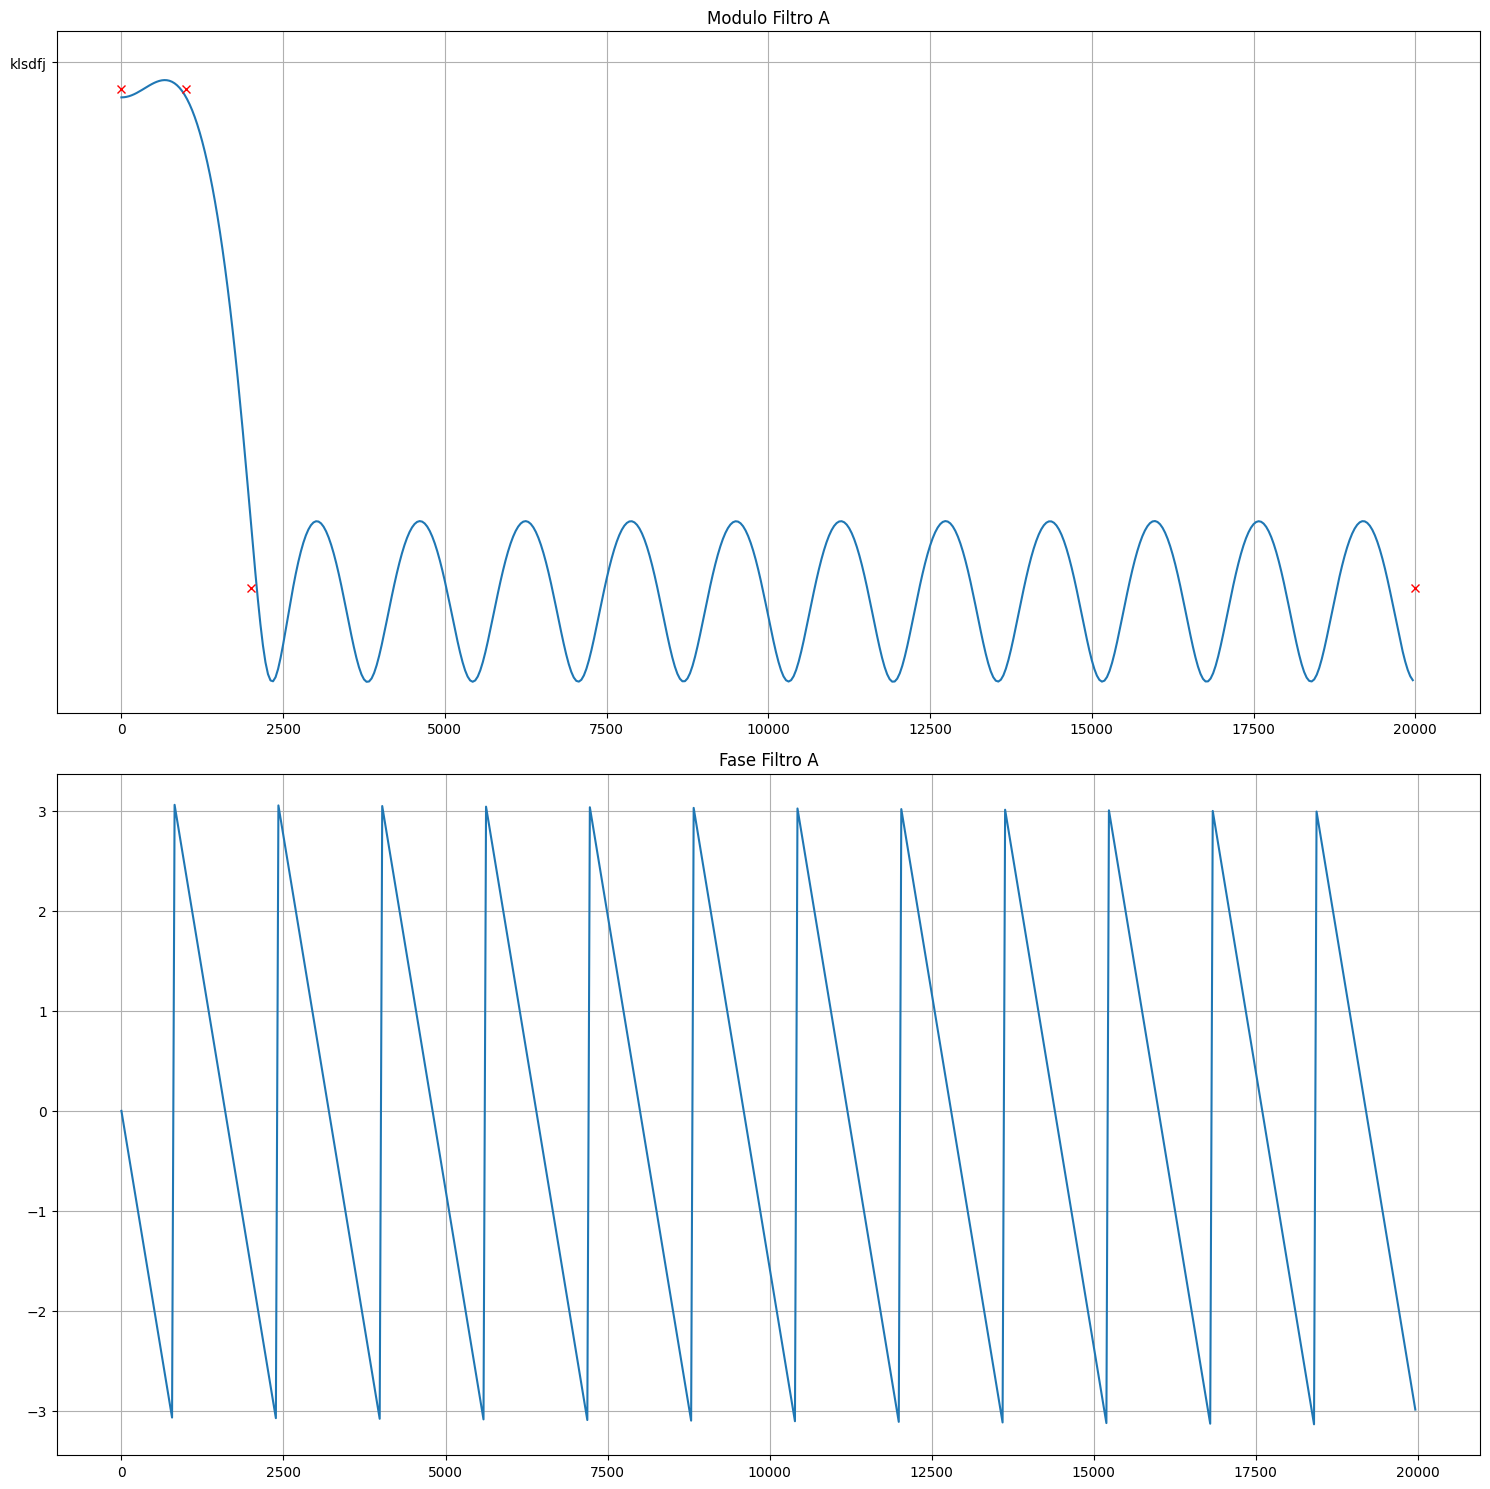

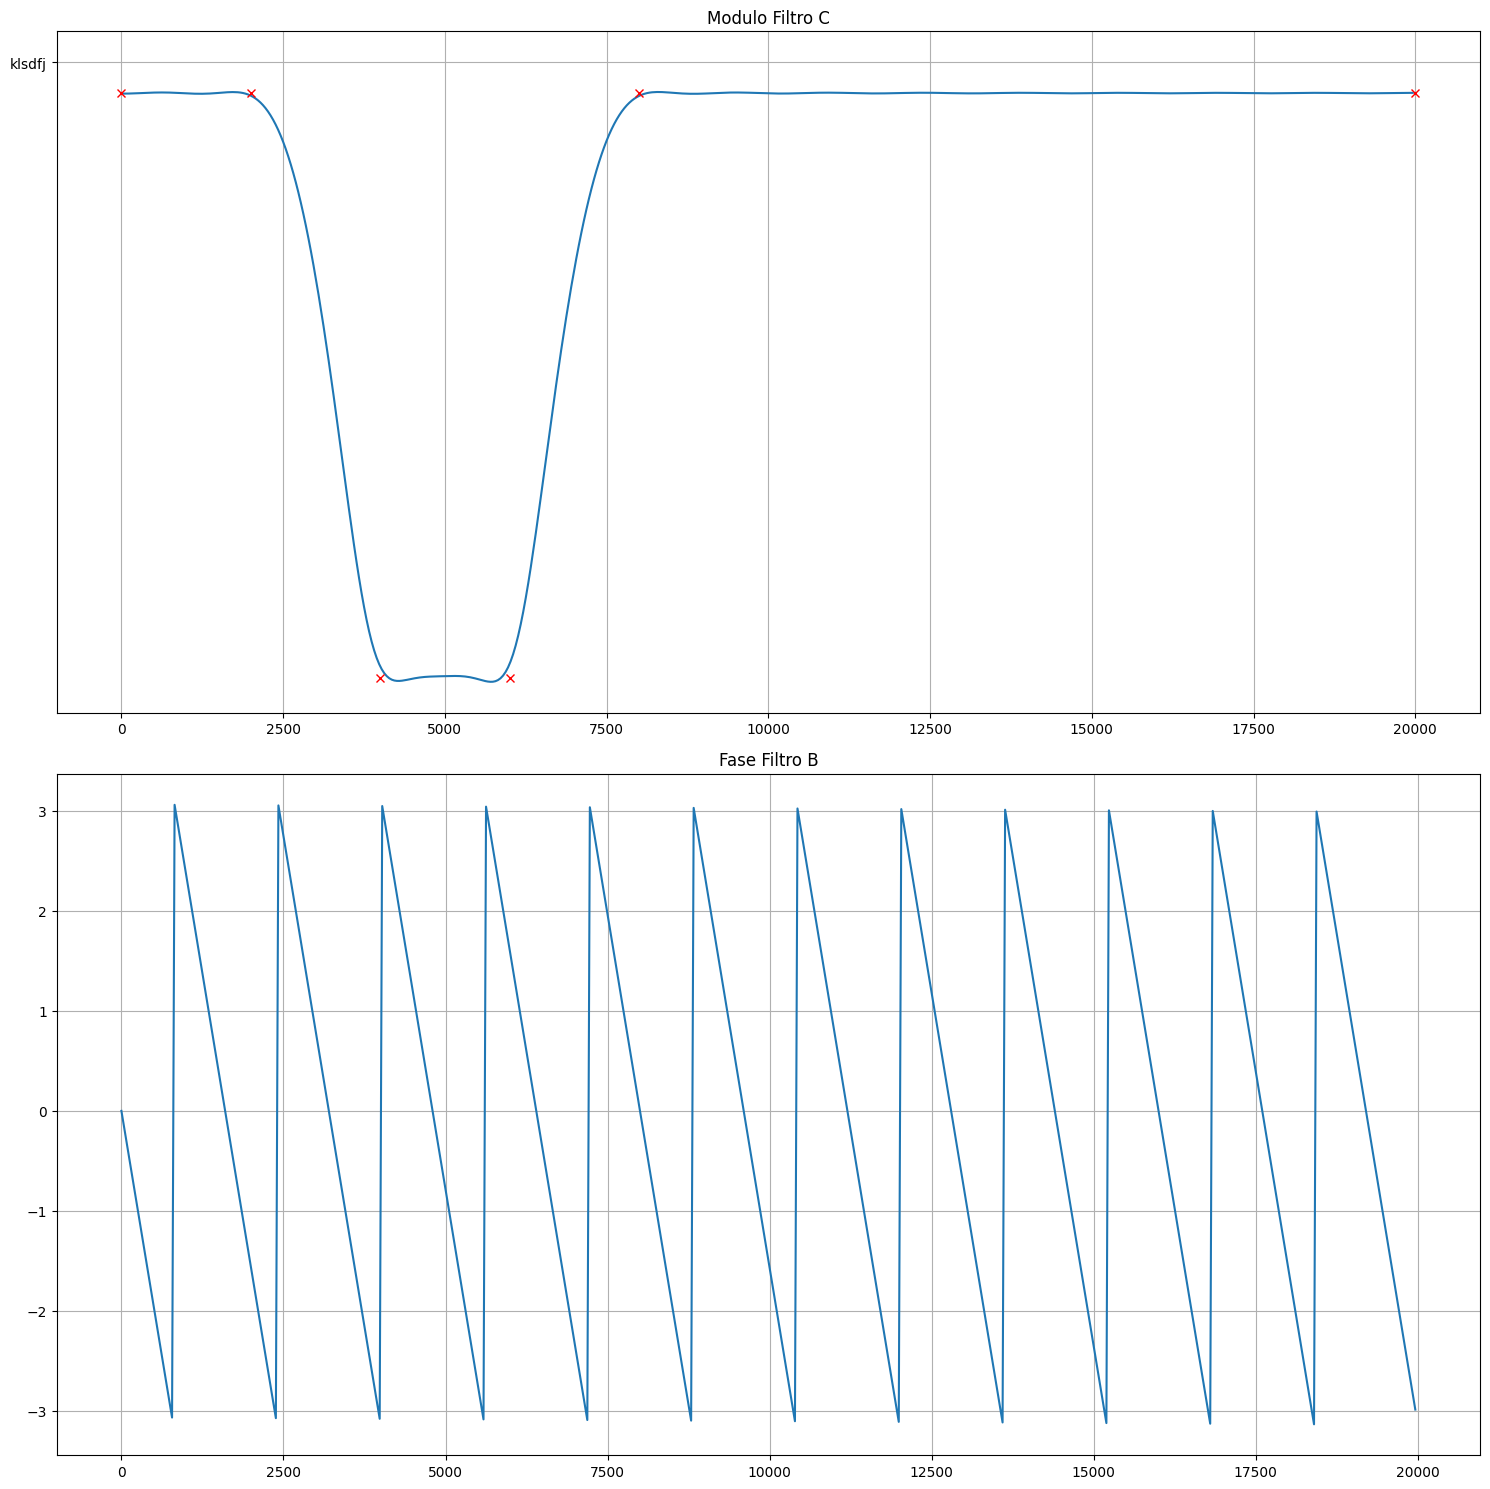

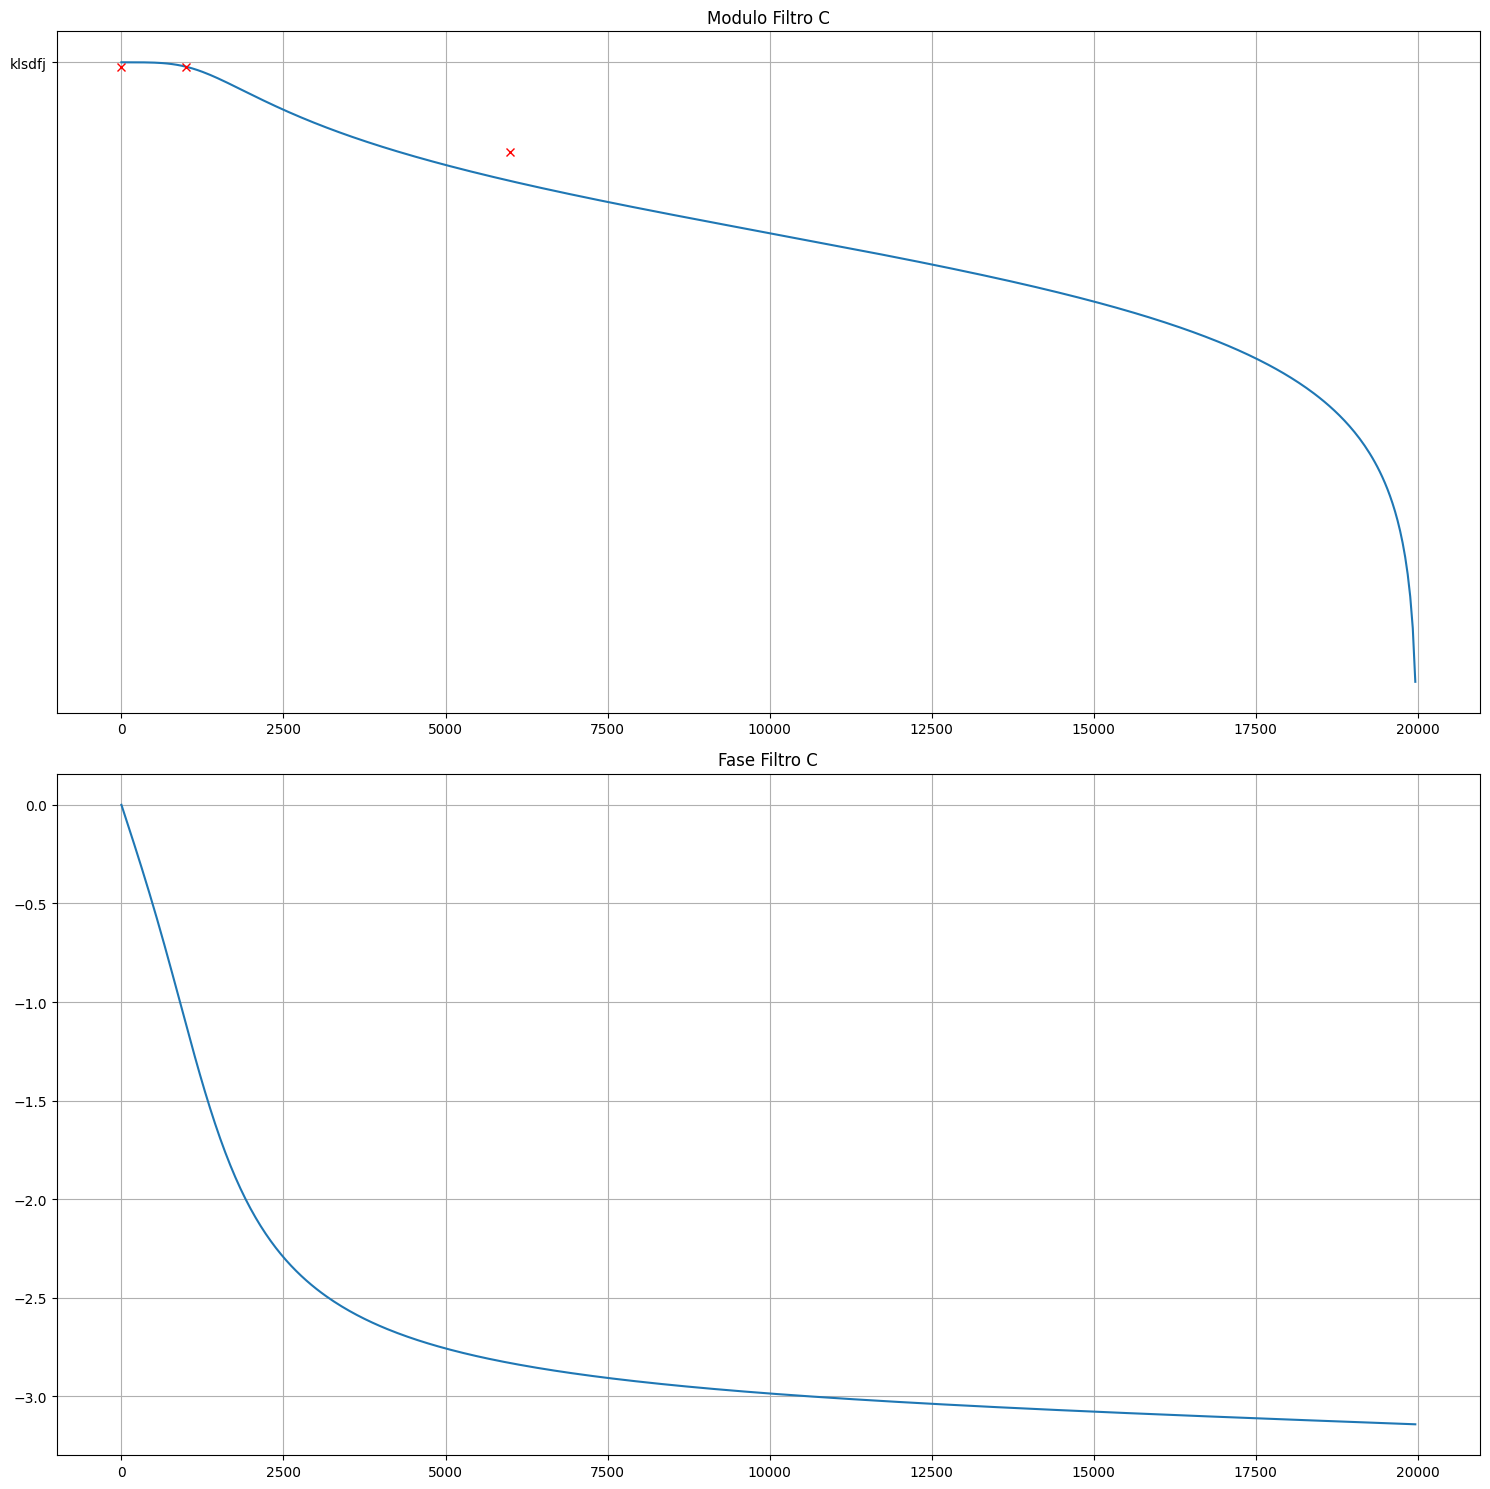

In [2]:
from numpy import genfromtxt
from IPython.display import display, Markdown
# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')
# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

############################## Nyquist
fs = 40000 # Hz
nyq_frec = fs / 2

############################## Plantilla
# filter design
alpha_min = 20
alpha_max = 1

############################# FILTRO A 
# LP equi ripple FIR
taps_a = 51
frecs_a = [0, 1000, 2000, nyq_frec]
gains_db_a = [-alpha_max, -alpha_min]
gains_db_a_2 = [-alpha_max, -alpha_max ,-alpha_min, -alpha_min]
gains_vs_a = 10**(np.array(gains_db_a)/20)
num_a = sig.remez(taps_a, frecs_a, gains_vs_a, fs=fs)
wz_a, hz_a = sig.freqz(num_a, 1.0)

############################# FILTRO B
# Stop Band
taps_b = 51
frecs_b = [0, 2000, 4000, 6000, 8000, nyq_frec]
gains_db_b = [-alpha_max, -alpha_max, -alpha_min, -alpha_min, -alpha_max, -alpha_max]
gains_vs_b = 10**(np.array(gains_db_b)/20)
num_b = sig.firls(taps_b, frecs_b, gains_vs_b, fs=fs)
wz_b, hz_b = sig.freqz(num_b, 1.0)

############################# FILTRO C
# LP IIR
frecs_c = [0, 1000, 6000, nyq_frec]
gains_db_c = [-1, -1, -20, -np.inf]
num_c, den_c = sig.iirdesign(
    wp=1000, 
    ws=6000, 
    gpass=alpha_max,
    gstop=alpha_min, 
    analog=False, 
    ftype='butter', 
    output='ba', 
    fs=fs
    )
wz_c, hz_c = sig.freqz(num_c, den_c)


### PLOT TF A
fig_a, ax_a = plt.subplots(2, 1, figsize=(15, 15))
ax_a[0].set_title("Modulo Filtro A")
ax_a[0].plot(wz_a*fs/(2*np.pi), 20*np.log10(hz_a))
ax_a[0].plot(frecs_a, gains_db_a_2, 'rx', 'klsdfj')
ax_a[0].grid()
ax_a[1].set_title("Fase Filtro A")
ax_a[1].plot(wz_a*fs/(2*np.pi), np.angle(hz_a))
ax_a[1].grid()
fig_a.tight_layout()

### PLOT TF B
fig_b, ax_b = plt.subplots(2, 1, figsize=(15, 15))
ax_b[0].set_title("Modulo Filtro C")
ax_b[0].plot(wz_b*fs/(2*np.pi), 20*np.log10(hz_b))
ax_b[0].plot(frecs_b, gains_db_b, 'rx', 'klsdfj')
ax_b[0].grid()
ax_b[1].set_title("Fase Filtro B")
ax_b[1].plot(wz_b*fs/(2*np.pi), np.angle(hz_b))
ax_b[1].grid()
fig_b.tight_layout()

### PLOT TF B
fig_c, ax_c = plt.subplots(2, 1, figsize=(15, 15))
ax_c[0].set_title("Modulo Filtro C")
ax_c[0].plot(wz_c*fs/(2*np.pi), 20*np.log10(hz_c))
ax_c[0].plot(frecs_c, gains_db_c, 'rx', 'klsdfj')
ax_c[0].grid()
ax_c[1].set_title("Fase Filtro C")
ax_c[1].plot(wz_c*fs/(2*np.pi), np.angle(hz_c))
ax_c[1].grid()
fig_c.tight_layout()

#### Etapa 2: Implementacion

Utilizando el framework provisto por la catedra corrimos los filtros sobre un LPC1769 usando la biblioteca CMSIS.

Para una correcta adquisicion y posterior reconstruccion de la señal de diseño un filtro pasabajos de primer orden RC.
Se coloco uno a la entrada del ADC y otro a la salida del DAC.

$\frac{v_o}{v_i} = \frac{\omega_o}{s + \omega_o}$

$\omega_o = \frac{1}{RC}$

Se definio $f_o = 10KzH$ y adoptamos $R = $


## Etapa 3: Validacion manual

Mediante el uso del osciloscopio levantamos los valores de $V_i$ $V_o$ y medimos el tiempo entre los picos de maximo valor de las señales para poder calcular la respuesta de fase de la funcion transferencia.

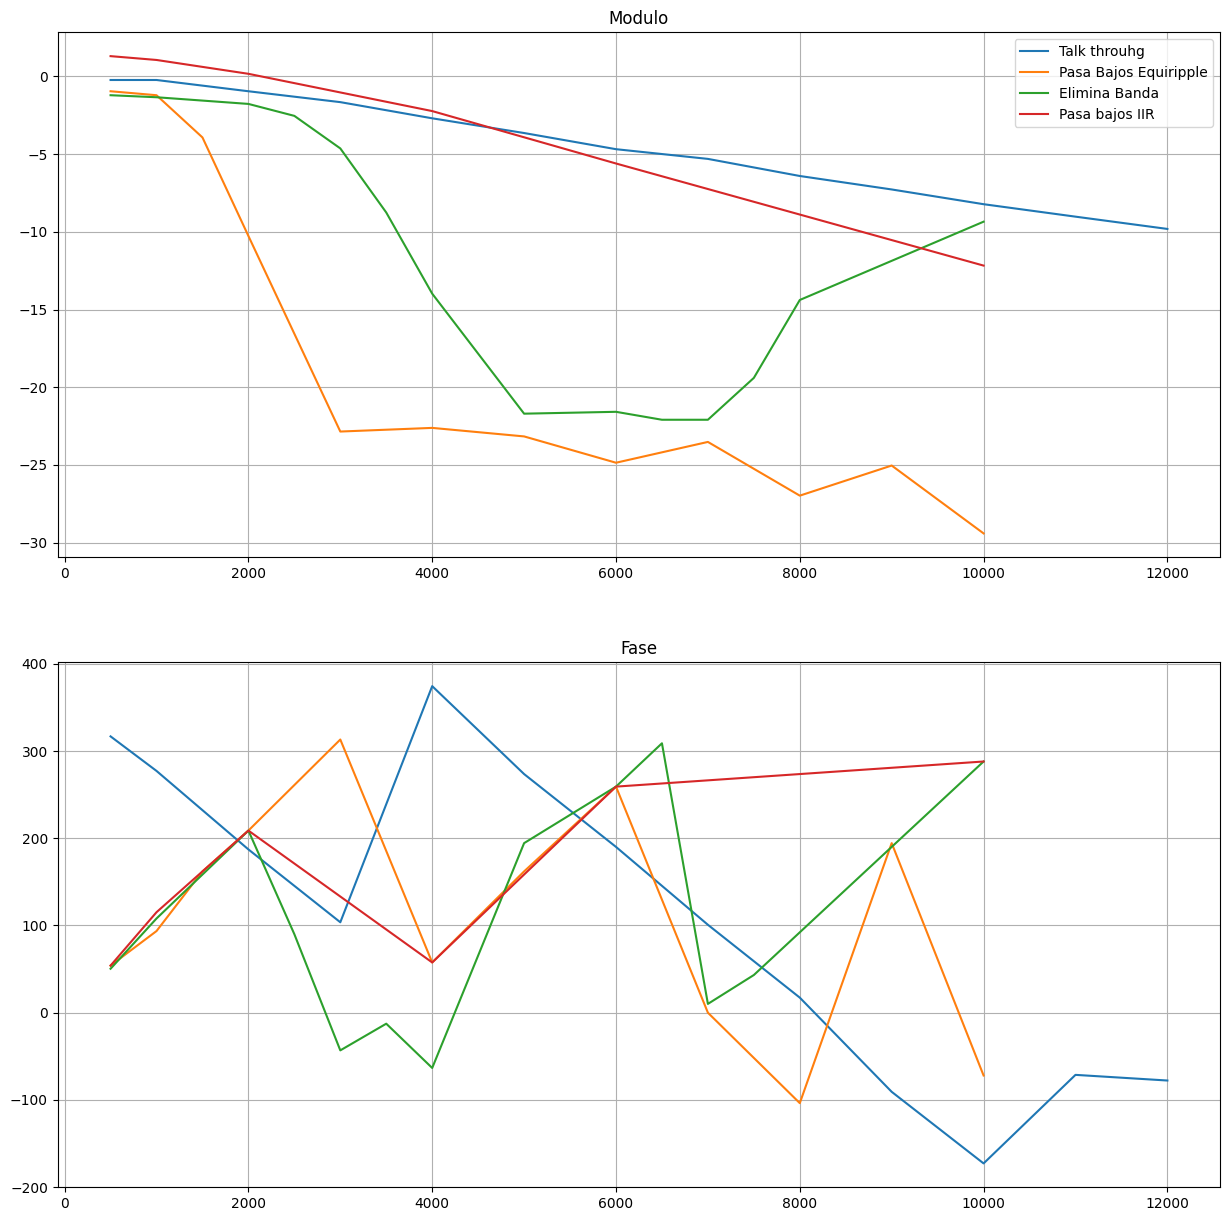

In [5]:
######################### Mediciones Manuales.
# Modulo y retrazo de senales en modo talkThrough
freqs_base_line = np.array([500,     1000,   2000,   3000,  4000,   5000,   6000,  7000,  8000, 9000,   10000,  11000, 12000])
times_base_line = np.array([1.76e-3, 770e-6, 260e-6, 96e-6, 260e-6, 152e-6, 88e-6, 40e-6, 6e-6, -28e-6, -48e-6, -18e-6, -18e-6])
vi_base_line = np.array([3.08, 3.08, 3.08, 3, 3, 2.92, 2.88, 2.8, 2.76, 2.68, 2.68, 2.6,  2.6])
vo_base_line = np.array([3, 3, 2.76, 2.48, 2.20, 1.92, 1.68, 1.52, 1.32, 1.16, 1.04, 0.92, 0.84])
phase_base_line = np.multiply(np.array(360*freqs_base_line), times_base_line)

# Modulo y retrazo para el filtro A
freqs_filter_a = np.array([500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
vi_filter_a = np.array(   [3.08, 3.08, 3.08, 3,    3,     2.92,  2.88, 2.8,  2.76,  2.68,  2.68, 2.6])
vo_filter_a = np.array(   [2.76, 2.68, 1.96, 0.92, 0.216, 0.216, 0.2,  0.16, 0.184, 0.12,  0.15, 0.088])
times_filter_a = np.array([300e-6, 260e-6, 300e-6, 290e-6, 290e-6, 40e-6, 90e-6, 120e-6, 0, -36e-6, 60e-6, -20e-6])
phase_filter_a = np.multiply(np.array(360*freqs_filter_a), times_filter_a)

# Modulo y retrazo para el filtro B
freqs_filter_b = np.array([500,    1000,   2000,   2500,   3000,   3500,   4000,   5000,   6000,   6500,  7000, 7500,   8000, 10000])
vi_filter_b = np.array(   [3.08,   3.08,   3.04,   3,      3,      2.96,   3,      2.92,   2.88,   2.8,    2.8,  2.8,   2.62,  2.64])
vo_filter_b = np.array(   [2.68,   2.64,    2.48,   2.24,   1.76,   1.08,   0.6,    0.24,   0.24,   0.22,  0.22, 0.3,   0.5,   0.9 ])
times_filter_b = np.array([280e-6, 300e-6, 290e-6, 100e-6, -40e-6, -10e-6, -44e-6, 108e-6, 120e-6, 132e-6, 4e-6, 16e-6, 32e-6, 80e-6])
phase_filter_b = np.multiply(np.array(360*freqs_filter_b), times_filter_b)

# Modulo y retrazo para el filtro C
freqs_filter_c = np.array([500,    1000,   2000,   4000,  6000,   10000])
vi_filter_c = np.array(   [3.08,   3.08,   3.04,   2.96,  2.84,   2.64])
vo_filter_c = np.array(   [3.58,   3.48,   3.1,    2.29,  1.49,   0.65])
times_filter_c = np.array([300e-6, 320e-6, 290e-6, 40e-6, 120e-6, 80e-6])
phase_filter_c = np.multiply(np.array(360*freqs_filter_c), times_filter_c)

amp_base_line = 20*np.log10(vo_base_line/vi_base_line)
amp_filter_a = 20*np.log10(vo_filter_a/vi_filter_a)
amp_filter_b = 20*np.log10(vo_filter_b/vi_filter_b)
amp_filter_c = 20*np.log10(vo_filter_c/vi_filter_c)

fig_man_1, ax_man_1 =  plt.subplots(2, 1, figsize = (15, 15))
ax_man_1[0].set_title('Modulo')
ax_man_1[0].plot(freqs_base_line, amp_base_line)
ax_man_1[0].plot(freqs_filter_a, amp_filter_a)
ax_man_1[0].plot(freqs_filter_b, amp_filter_b)
ax_man_1[0].plot(freqs_filter_c, amp_filter_c)
ax_man_1[0].legend(["Talk throuhg", "Pasa Bajos Equiripple", "Elimina Banda", "Pasa bajos IIR"])

ax_man_1[0].grid()
ax_man_1[1].set_title('Fase')
ax_man_1[1].plot(freqs_base_line, phase_base_line)
ax_man_1[1].plot(freqs_filter_a, phase_filter_a)
ax_man_1[1].plot(freqs_filter_b, phase_filter_b)
ax_man_1[1].plot(freqs_filter_c, phase_filter_c)
ax_man_1[0].legend(["Talk throuhg", "Pasa Bajos Equiripple", "Elimina Banda", "Pasa bajos IIR"])

ax_man_1[1].grid()

## Etapa 4: Validacion utlizando un analizador de audio

Luego de haber obtenido una respuesta aproximada de la respuesta en modulo de cada uno de los 3 filtros y que confirmamos que las implementaciones responden acorde a lo esperado ensayamos los filtros con un analizador de audio.

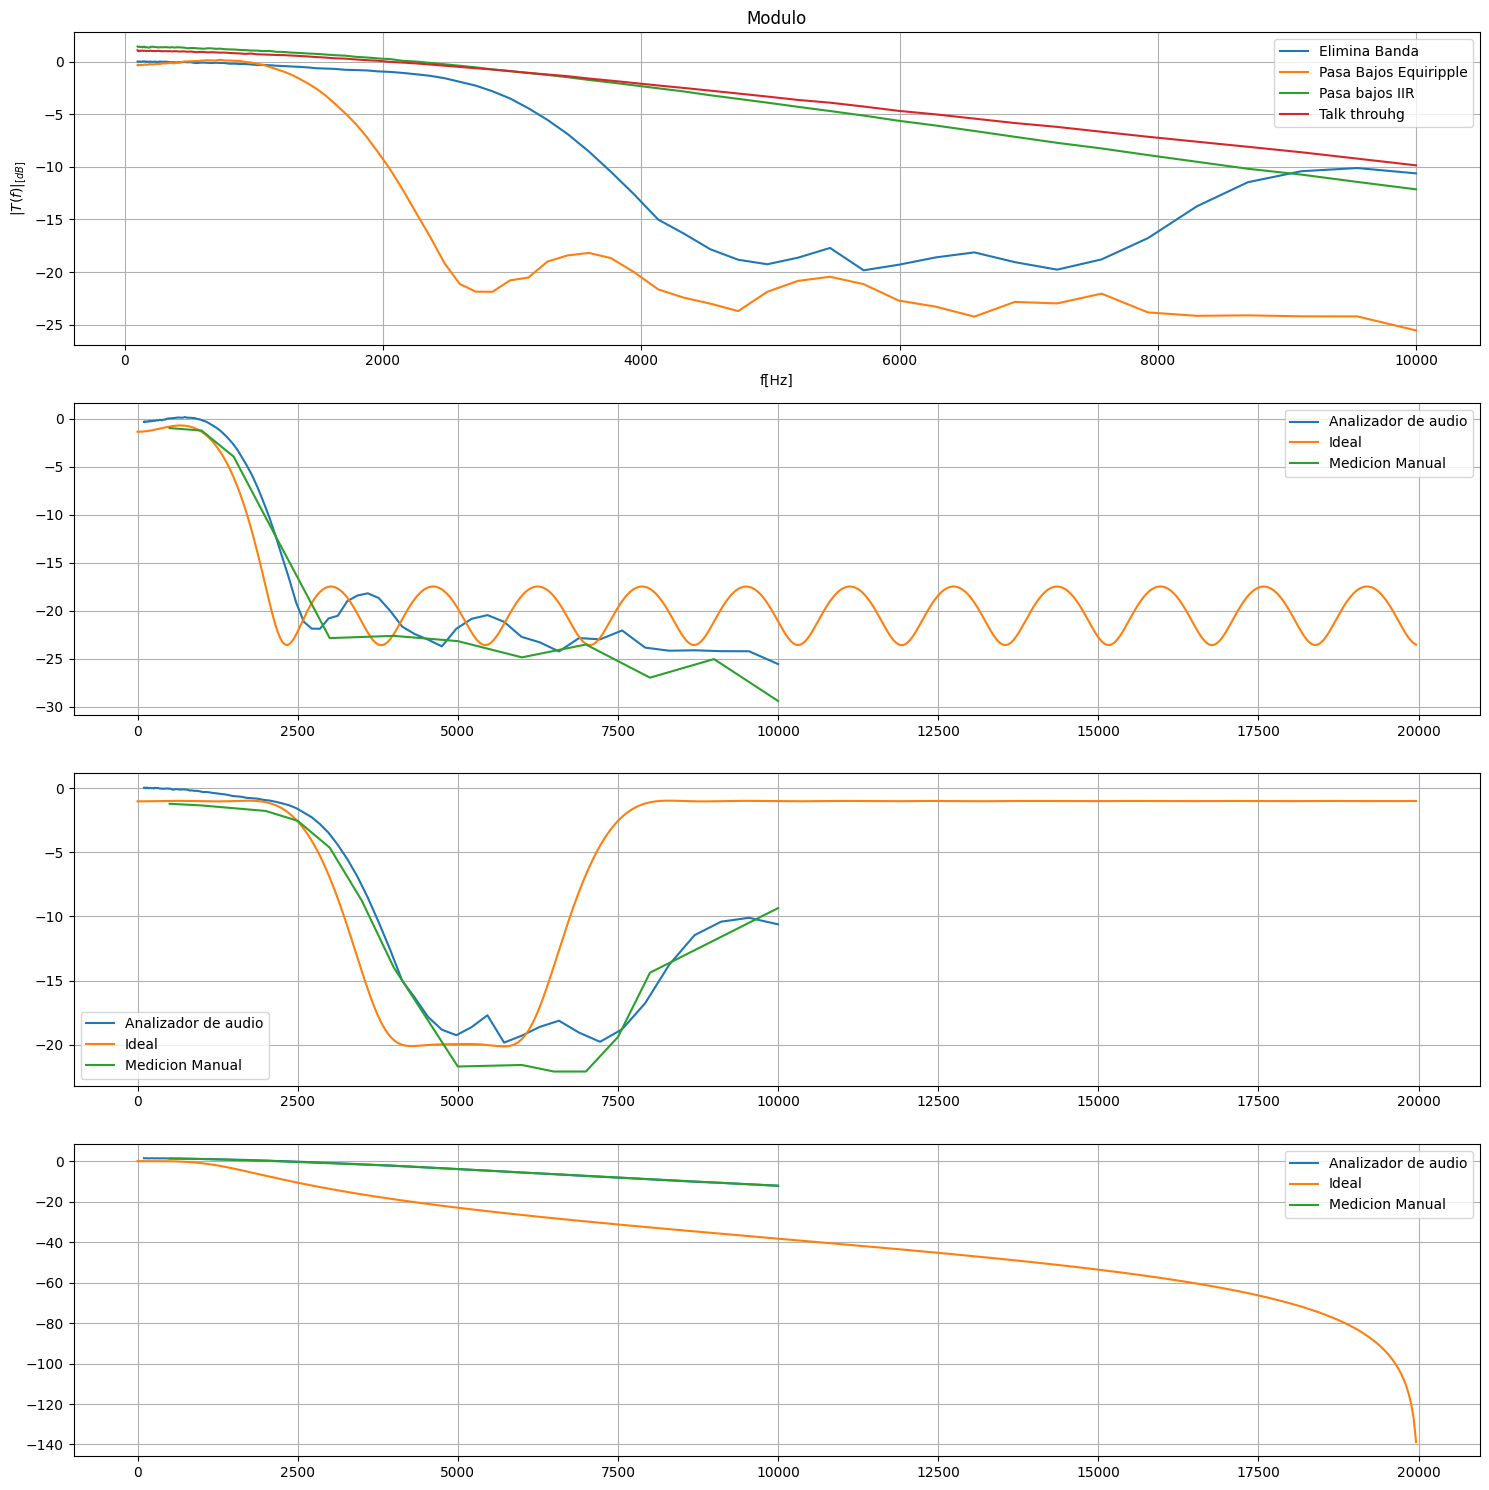

In [10]:
#levantamos los valores de modulo (previeamente descartamos el header y otro relleno del csv.)
# TODO obtener los valores con el analizado de audio y plotearlos junto a los valores obtenidos manualmente.
raw_data_0 = genfromtxt('csv/raw_data_0.csv', delimiter = ',') 
raw_data_1 = genfromtxt('csv/raw_data_1.csv', delimiter = ',')
raw_data_2 = genfromtxt('csv/raw_data_2.csv', delimiter = ',')
raw_data_3 = genfromtxt('csv/raw_data_3.csv', delimiter = ',')

freq_0 = raw_data_0[:,0]
mod_0 = raw_data_0[:,1]
freq_1 = raw_data_1[:,0]
mod_1 = raw_data_1[:,1]
freq_2 = raw_data_2[:,0]
mod_2 = raw_data_2[:,1]
freq_3 = raw_data_3[:,0]
mod_3 = raw_data_3[:,1]

#configuramos la cantidad de graficos, 3 filas 1 columna
figure, axes = plt.subplots(4,1, figsize=(15, 15))
axes[0].plot(freq_0, mod_0)
axes[0].plot(freq_1, mod_1)
axes[0].plot(freq_2, mod_2)
axes[0].plot(freq_3, mod_3)
axes[0].set_ylabel(r'$|T(f)|_{[dB]}$')
axes[0].set_xlabel('f[Hz]')
axes[0].grid()
axes[0].set_title("Modulo")
axes[0].legend(["Elimina Banda","Pasa Bajos Equiripple", "Pasa bajos IIR", "Talk throuhg"])
axes[1].plot(freq_1, mod_1, wz_a*fs/(2*np.pi), 20*np.log10(hz_a), freqs_filter_a, amp_filter_a)
axes[1].legend(["Analizador de audio","Ideal", "Medicion Manual"])
axes[1].grid()
axes[2].plot(freq_0, mod_0, wz_b*fs/(2*np.pi), 20*np.log10(hz_b), freqs_filter_b, amp_filter_b)
axes[2].legend(["Analizador de audio","Ideal", "Medicion Manual"])
axes[2].grid()
axes[3].plot(freq_2, mod_2, wz_c*fs/(2*np.pi), 20*np.log10(hz_c), freqs_filter_c, amp_filter_c)
axes[3].legend(["Analizador de audio","Ideal", "Medicion Manual"])
axes[3].grid()
#limitamos el grafico a los valores de frecuencia disponibles.
#axes[0].set_xlim([x_0_lower_limit, x_0_upper_limit])
#no limitamos en y, la libreria lo esta resolviendo mejor que nosotros.
#axes[0].set_ylim([y_0_lower_limit, y_0_upper_limit])
figure.tight_layout()


## Conclusiones: SON DEL TPL1

### Amplitud
La respuesta en modulo de los filtros esta modulada por la respuesta de los filtros pasabajos de entrada y salida del sistema. En el filtro que mas se hace presente este efecto es en el elimina banda, ya que en la zona de alta frecuencia la transferencia empieza a atenuar por la atenuacion sumada del filtro de entrada y el de salida.
En el caso de los filtros pasabajos este efecto pasa desapercibido ya que la atenuacion del pasabajos de entrada y el de salida se suman al del pasabajos diseñado mejorando su comportamiento.

### Fase

En la validacion manual de la transferencia de los filtros se toman poca muestras y esto hace que no sea posible graficar una fase que se corresponda con la esperada. Luego al medir con el analizador de audio la cantidad de muestras es superior y se podria graficar la fase, pero debido a la implementacion por buffers propia de la CMSIS la fase que se obtiene no es la esperada. La implementacion de filtrado utilizada para el filtrado no conserva la fase del sistema simulado.

### Retardo de grupo
Al no tener mediciones de fase correcta no podemos calcular el retardo de grupo de forma correcta.

### Filtro IIR
No se pudo validar el filtro IIR diseñado ya que el mismo tenia un comportamiento inestable al realizar el barrido en frecuencia, por ello se realizaron las mediciones con un filtro de orden 1. Como consecuencia de esto el filtro IIR es el que presenta mayor divergencia entre lo simulado y lo obtenido en el laboratorio.

### Resultado Final
Luego de superar todos los obstáculos de medición, se pudo validar que el filtro sintetizado cumple con el requisito de diseño.